# Cleaned Analysis of June 2nd Flight Test

## Naming and Folders

In [1]:
### Definining name of analysis ###
name = '2023-06-02-a_Linus_Acceleration_Analysis_Cleaned_IMU_NA'
data_path = '../../data/'
data_folder = 'linus-2023-06-02'
file_name = '00000018.BIN'
datasave_path = data_path+data_folder+'/'
result_path = '../Results/'+name+'/'
figure_path = '../Figures/'+name+'/'

## Importing Packages and Libraries

In [2]:
# Getting packages #
from os import sys
import os
sys.path.append('../../')

%matplotlib widget

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import plotly.express as px

import main
import propellers
import motors
from aircraft import airplane
import cl_finders

### Creating Folders for Results/Data ###
if not os.path.exists(result_path):
    os.makedirs(result_path)
if not os.path.exists(figure_path):
    os.makedirs(figure_path)
    
# Setting Plot Defaults
plt.style.use('../../basic_plotter.mplstyle')

## Importing Data

In [3]:
# Importing data, specifying import characteristics, backing up results
rate = "10ms"
interpolateM = "linear"
processor = "ArduPlane_4_3_3"
df = main.data_load(data_path, data_folder, file_name, rate, interpolateM, processor)

Recording    - INFO     - Loading recording file using reader: ArdupilotDFReader and processor: AP433Dataflash
ArdupilotDFReader - INFO     - Begin processing ../../data/linus-2023-06-02/00000018.BIN
ArdupilotDFReader - INFO     - GPS time found on channel=GPS, instance=1
ArdupilotDFReader - INFO     - 2023-06-03 03:26:01.600000 at board time = 1970-01-01 00:00:56.445856


In [4]:
build_turbulent = pd.read_pickle("../../DragBuilds/Linus_DragBuildTurbulent.pkl")
build_laminar = pd.read_pickle("../../DragBuilds/Linus_DragBuildLaminar.pkl")

## Defining Vehicle Parameters

In [106]:
# Vehicle parameters
prop = propellers.aeronaut11x7_estimatedBEN() # Using aeronaut 20x8 for this flight
motor = motors.U7V2_280KV()  # Using U7 V2 motor

mass = 1.820 # Estimated with virtual bolt included
span = 2.54
chord = 0.149
linus = airplane(mass, chord, span)
linus.area = 0.367
linus.AR = 17.583

## Manually Selecting Masks by Plots

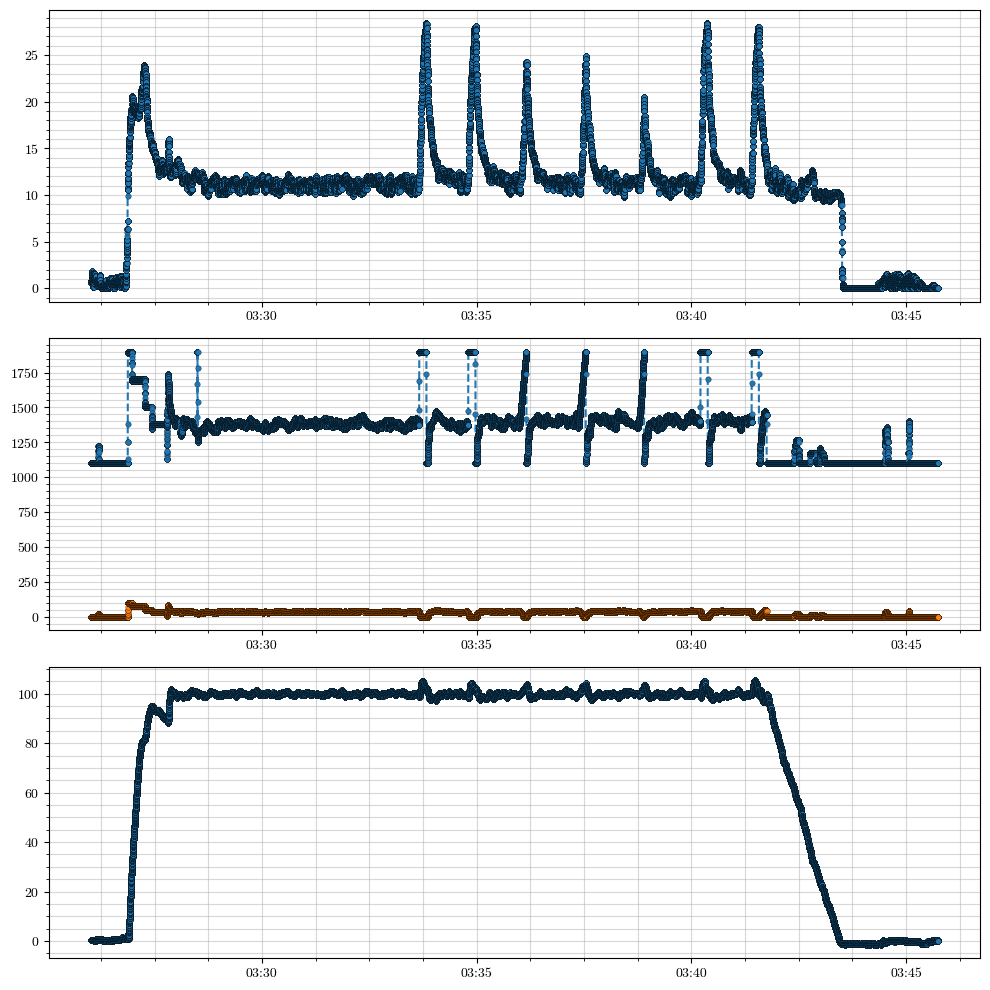

In [107]:
# Generating Plots
plt.figure(figsize=(10,10))
ax0 = plt.subplot(3,1,1)
plt.grid("On")
plt.plot(df.index, df.Airspeed_Sensor0, linestyle='--', marker='o', markersize=4, markeredgecolor=[0,0,0])
ax1 = plt.subplot(3,1,2, sharex=ax0)
plt.grid("On")
plt.plot(df.index, df.ThrottleOut, linestyle='--', marker='o', markersize=4, markeredgecolor=[0,0,0])
plt.plot(df.index, df.Throttle, linestyle='--', marker='o', markersize=4, markeredgecolor=[0,0,0])
ax2 = plt.subplot(3,1,3, sharex=ax0)
plt.grid("On")
plt.plot(df.index, df.Altitude_BARO_0, linestyle='--', marker='o', markersize=4, markeredgecolor=[0,0,0])
plt.grid("On")
plt.show()

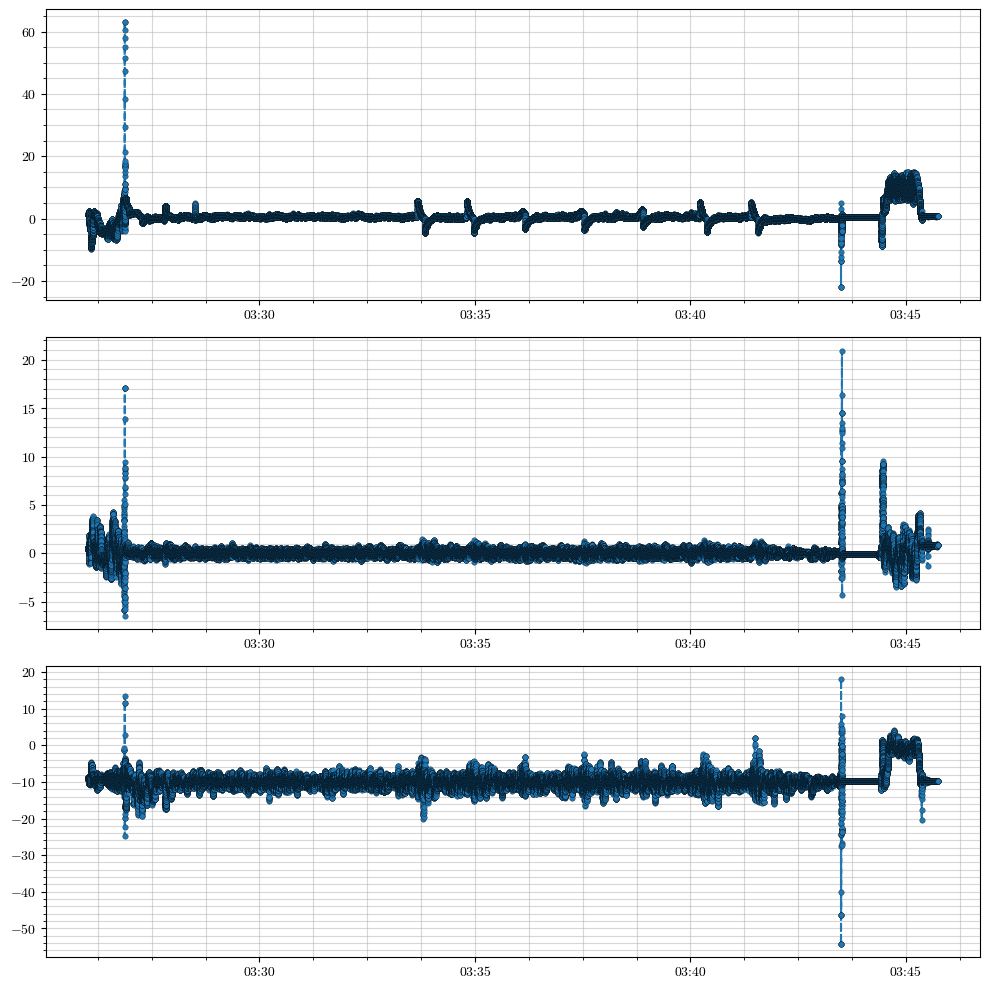

In [108]:
plt.figure(figsize=(10,10))
ax0 = plt.subplot(3,1,1)
plt.grid("On")
plt.plot(df.index, df.XAcc_IMU0, linestyle='--', marker='o', markersize=4, markeredgecolor=[0,0,0])
ax1 = plt.subplot(3,1,2, sharex=ax0)
plt.grid("On")
plt.plot(df.index, df.YAcc_IMU0, linestyle='--', marker='o', markersize=4, markeredgecolor=[0,0,0])
ax2 = plt.subplot(3,1,3, sharex=ax0)
plt.grid("On")
plt.plot(df.index, df.ZAcc_IMU0, linestyle='--', marker='o', markersize=4, markeredgecolor=[0,0,0])
plt.grid("On")
plt.show()

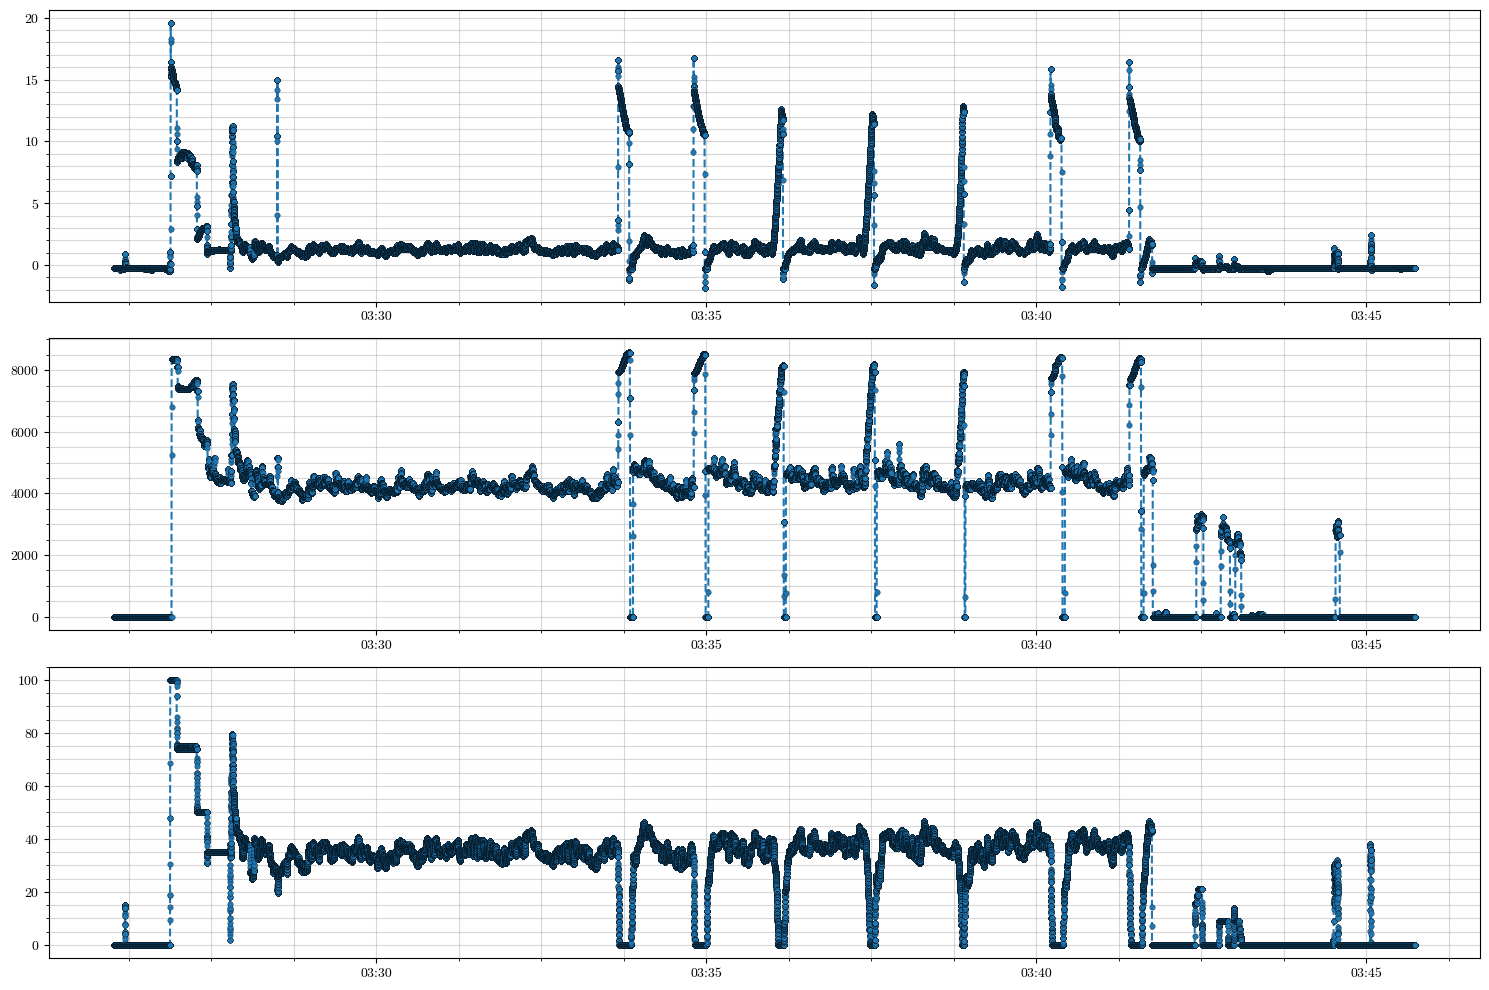

In [109]:
# Generating Plots

plt.figure(figsize=(15,10))
plt.tight_layout()

ax0 = plt.subplot(3,1,1)
plt.grid("On")
ax0.plot(df.index, df.MainBatteryCurrent, linestyle='--', marker='o', markersize=4, markeredgecolor=[0,0,0])

ax0 = plt.subplot(3,1,2, sharex=ax0)
plt.grid("On")
ax0.plot(df.index, df.MotorRPM, linestyle='--', marker='o', markersize=4, markeredgecolor=[0,0,0])

ax2 = plt.subplot(3,1,3, sharex=ax0)
ax2.plot(df.index, df.Throttle, linestyle='--', marker='o', markersize=4, markeredgecolor=[0,0,0])
plt.grid("On")
plt.show()

### Results of Manual Segmentation
#### Acceleration Segmentation

In [110]:
### Mask Initialization ###
year = 2023
month = 6
day = 3

# Cruise Masking

seg_times = np.array([['03:33:41','03:33:49'],
                      ['03:34:49','03:34:58'],
                      ['03:35:59','03:36:09'],
                      ['03:37:22','03:37:32'],
                      ['03:38:44','03:38:53'],
                      ['03:40:14','03:40:22'],
                      ['03:41:25', '03:41:34']])
                      
masks = cl_finders.get_maskarray(df, seg_times, year, month, day)

#### Calibration Segmentation

In [111]:
### Mask Initialization ###
year = 2023
month = 6
day = 3

# Cruise Masking

seg_times = np.array([['03:43:40','03:44:20']])
cal_masks = cl_finders.get_maskarray(df, seg_times, year, month, day)

## Checking Segmentation for Good Data

In [112]:
############# Main Analysis ###############3

# Gravity
g = 9.807

# Attitude 
phi = np.deg2rad(df["RollAngle"].to_numpy())            # Bank angle in radians
theta = np.deg2rad(df["PitchAngle"].to_numpy())         # Pitch angle in radians

# Atmospheric adjustments:
rho = df["Pressure_BARO0"].to_numpy() * (287 * (df["Temperature_ARSP"].to_numpy()+273.15))**-1             # Density found from barometer pressure & airspeed sensor temperatures
v_eas = df["Airspeed_Sensor0"].to_numpy()                               # Equivalent SSL airspeed (m/s)
v_tas = v_eas * np.sqrt(1.225) * np.sqrt(rho)**-1   # the true airspeed
q = 0.5 * rho * v_tas**2                            # Dynamic pressure 

# For Descent method
h = df["Altitude_POS"].to_numpy()                   # Altitude
Vd_eas = df["DescentRate"].to_numpy()                  # Descent Rate from EKF (is it true or EAS at SSL?)
Vd_tas = Vd_eas * np.sqrt(1.225) * np.sqrt(rho)**-1   # the true airspeed

# Propulsion characterization
n = df["MotorRPM"].to_numpy() / 60                               # Revolutions per second
i_esc = df["MainBatteryCurrent"].to_numpy()                      # Really the ESC voltage and current here
v_esc = df["MainBatteryVoltage"].to_numpy()
J = v_tas / (n * prop.diameter)
eff = prop.efficiency(J) * motor.efficiency(n, i_esc)

# Inertial Measurement Unit
xp_acc = df["XAcc_IMU0"].to_numpy()                       # Acceleration in X direction of the IMU
yp_acc = df.YAcc_IMU0.to_numpy()                       # Acceleration in Y direction of the IMU
zp_acc = df["ZAcc_IMU0"].to_numpy()                       # Acceleration in Z direction of the IMU

U_dot = xp_acc - 9.807 * np.sin(theta)
W_dot = zp_acc + 9.807 * np.cos(theta) * np.cos(phi)

gamma = np.arcsin(-Vd_tas/v_tas)
alpha = theta-gamma

U = v_tas * np.cos(alpha)
V = 0
W = v_tas * np.sin(alpha)

P = df.GyroX_IMU0 
Q = df.GyroY_IMU0
R = df.GyroZ_IMU0

/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_59779/1205249789.py:36: RuntimeWarning: divide by zero encountered in true_divide
  gamma = np.arcsin(-Vd_tas/v_tas)
/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_59779/1205249789.py:36: RuntimeWarning: invalid value encountered in arcsin
  gamma = np.arcsin(-Vd_tas/v_tas)


### Plotting Airspeeds, Altitude and Motor RPM for Checks

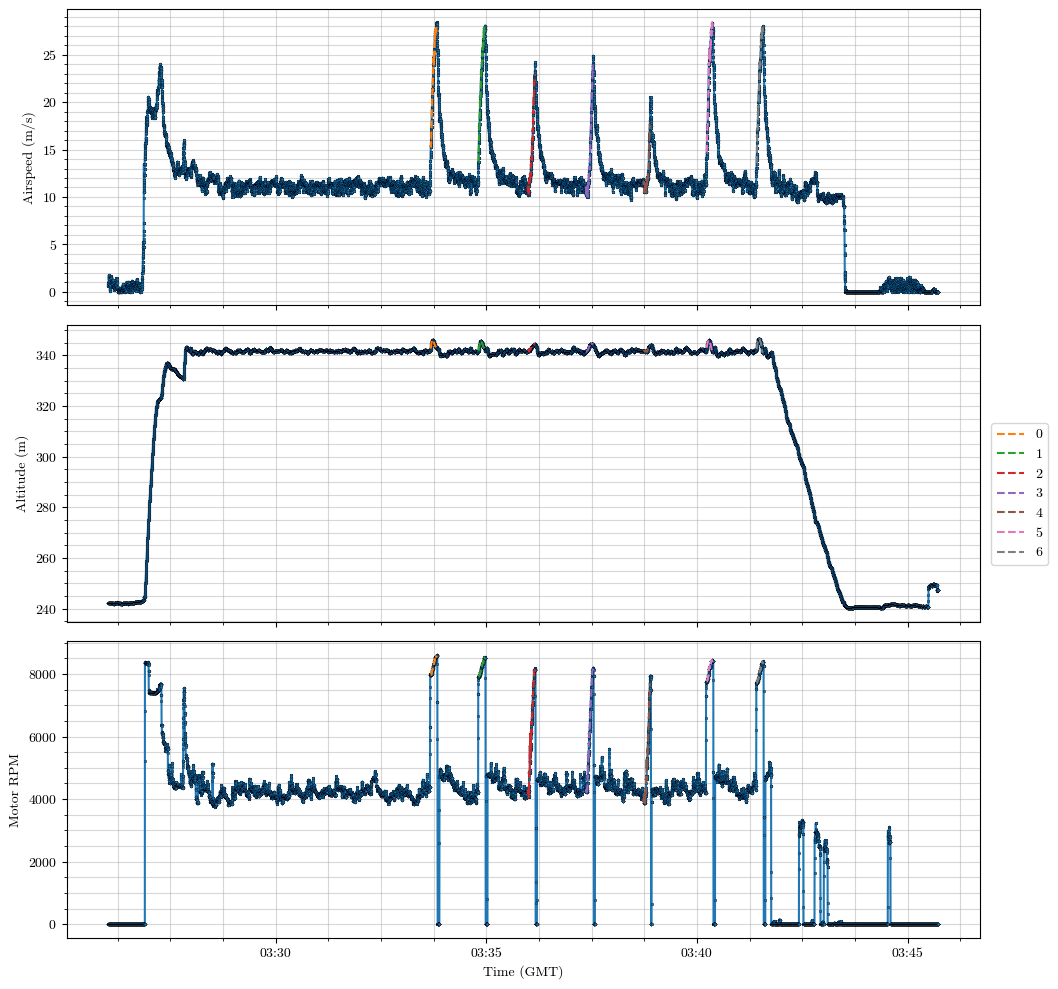

Plot already exists


In [113]:
# Airspeed for Segments
[timeindex_v_h_RPM_fullsegmented, axs] = plt.subplots(3,1, sharex=True, figsize=(10,10), dpi=100)
# timeindex_v_h_RPM_segmented.subplots_adjust(right=0.2, left=0.1)

axs[0].plot(df.index, df.Airspeed_Sensor0)
for i in np.arange(len(masks)):
    axs[0].plot(df.Airspeed_Sensor0[masks[i]], marker='', linestyle='--', label=str(i) + "")
axs[0].set_ylabel("Airspeed (m/s)")

# Altitude for Segments
axs[1].plot(df.index, df.Altitude_POS)
for i in np.arange(len(masks)):
    axs[1].plot(df.Altitude_POS[masks[i]], marker='', linestyle='--')#, label=str(i) + "")
axs[1].set_ylabel("Altitude (m)")
# axs[1].legend(loc='center left',
#           ncol=2, fancybox=True, bbox_to_anchor=(1.04, 0.5))

# RPM for Segments
axs[2].plot(df.index, df.MotorRPM)
for i in np.arange(len(masks)):
    axs[2].plot(df.MotorRPM[masks[i]], marker='', linestyle='--')#, label=str(i) + "")
axs[2].set_ylabel("Motor RPM")
axs[2].set_xlabel("Time (GMT)")

timeindex_v_h_RPM_fullsegmented.legend(loc=7, bbox_to_anchor=(1.06, 0.5))
#timeindex_v_segmented.tight_layout(rect=[0, 0, 1.2, 1.2])
plt.show()
main.save_figure(timeindex_v_h_RPM_fullsegmented, f'{timeindex_v_h_RPM_fullsegmented=}'.split('=')[0], figure_path)

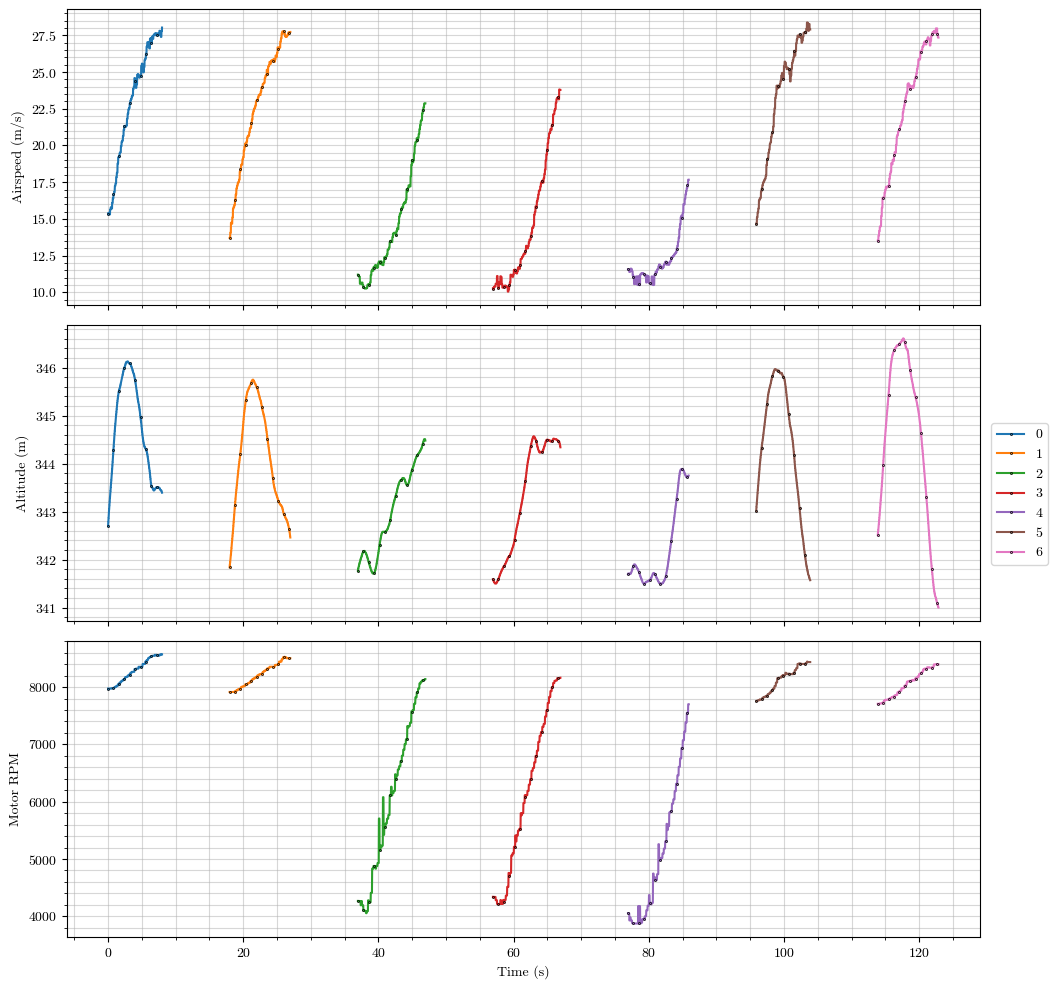

Plot already exists


In [114]:
# Airspeed for Segments
[timeindex_v_h_RPM_segmented, axs] = plt.subplots(3,1, sharex=True, figsize=(10,10), dpi=100)
# timeindex_v_h_RPM_segmented.subplots_adjust(right=0.2, left=0.1)

markerevery=80
markedgew=0.5
t_init = 0
dT = 0.01
for i in range(len(masks)):
    segment_length = len(v_tas[masks[i]])            # Integer segment length
    time_s = np.linspace(t_init, (segment_length-1)*dT + t_init, segment_length)
    # Airspeed for Segments
    axs[0].plot(time_s, df.Airspeed_Sensor0[masks[i]], linestyle='-', markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew,label=str(i) + "")
    # Altitude for Segments
    axs[1].plot(time_s, df.Altitude_POS[masks[i]], linestyle='-' , markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)#, label=str(i) + "")
    # RPM for Segments
    axs[2].plot(time_s, df.MotorRPM[masks[i]], linestyle='-', markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)#, label=str(i) + "")
    t_init = time_s[-1]+10
axs[0].set_ylabel("Airspeed (m/s)")
axs[1].set_ylabel("Altitude (m)")
axs[2].set_ylabel("Motor RPM")
axs[2].set_xlabel("Time (s)")

timeindex_v_h_RPM_segmented.legend(loc=7, bbox_to_anchor=(1.06, 0.5))
#timeindex_v_segmented.tight_layout(rect=[0, 0, 1.2, 1.2])
plt.show()
main.save_figure(timeindex_v_h_RPM_segmented, f'{timeindex_v_h_RPM_segmented=}'.split('=')[0], figure_path)

### Showing Rotational Rate of Vehicle

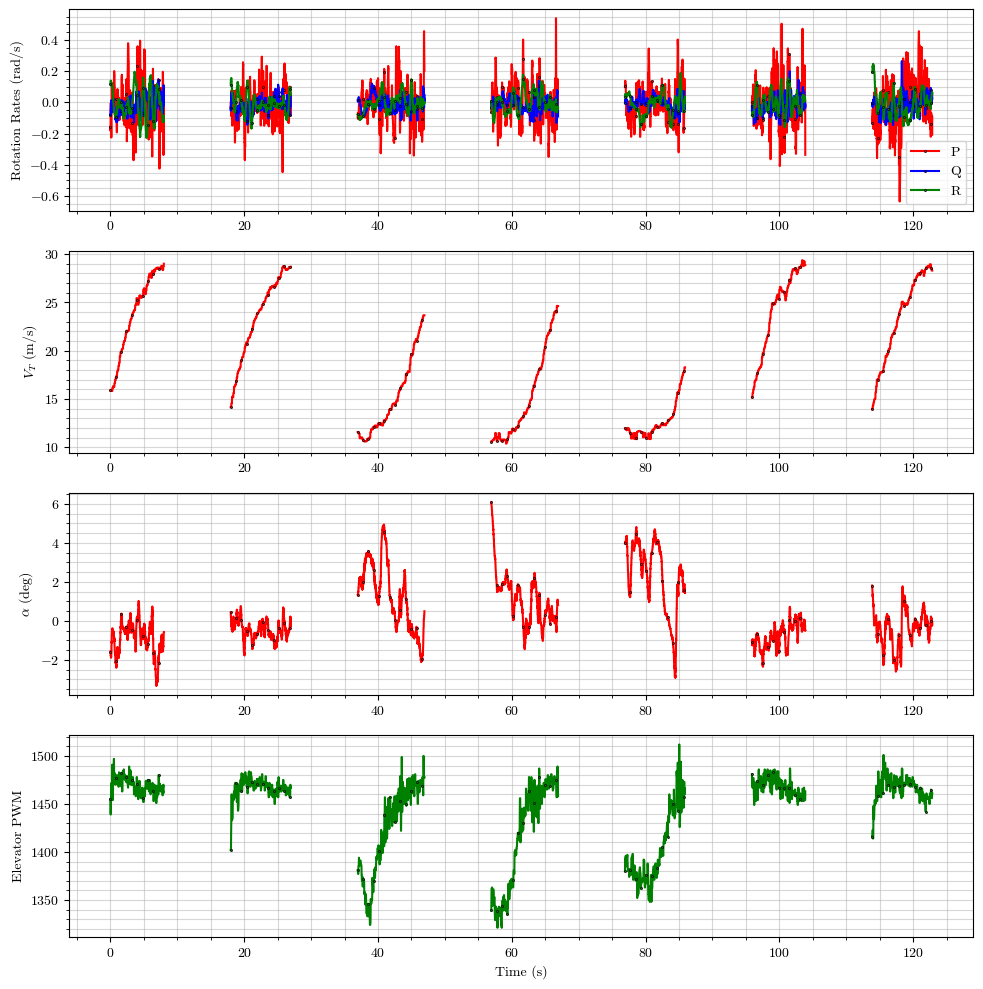

Plot already exists


In [115]:
timeindex_PQR_V_alpha_PWM_segmented = plt.figure(figsize=(10,10))
plt.tight_layout()
t_init = 0
markerevery=80
markedgew=0.5

ax1 = plt.subplot(4,1,1)
ax2 = plt.subplot(4,1,2, sharex=ax1)
ax3 = plt.subplot(4,1,3, sharex=ax1)
ax4 = plt.subplot(4,1,4, sharex=ax1)
for i in range(len(masks)):
    dT = 0.01
    segment_length = len(v_tas[masks[i]])            # Integer segment length
    time_s = np.linspace(t_init, (segment_length-1)*dT + t_init, segment_length)
    ax1.plot(time_s, P[masks[i]], color='r', markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, label='P')
    ax1.plot(time_s, Q[masks[i]], color='b', markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, label='Q')
    ax1.plot(time_s, R[masks[i]], color='g', markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, label='R')
    if i == 0:
        ax1.legend()
    ax1.set_ylabel("Rotation Rates (rad/s)")
    ax2.plot(time_s, v_tas[masks[i]], color='r', markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    ax2.set_ylabel("$V_T$ (m/s)")
    ax3.plot(time_s, np.rad2deg(alpha[masks[i]]), color='r', markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    ax3.set_ylabel("$\\alpha$ (deg)")
    ax4.plot(time_s, df.ElevatorOut[masks[i]], color='g', markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    ax4.set_ylabel("Elevator PWM")
    ax4.set_xlabel("Time (s)")
    t_init = time_s[-1]+10
plt.show()
main.save_figure(timeindex_PQR_V_alpha_PWM_segmented, f'{timeindex_PQR_V_alpha_PWM_segmented=}'.split('=')[0], figure_path)

### Checking IMU calibration Segment

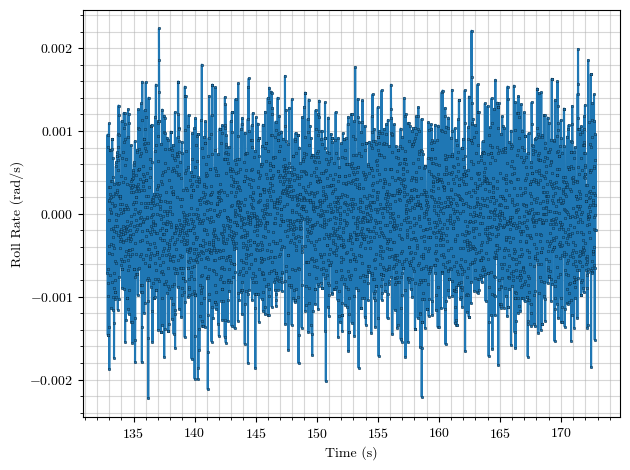

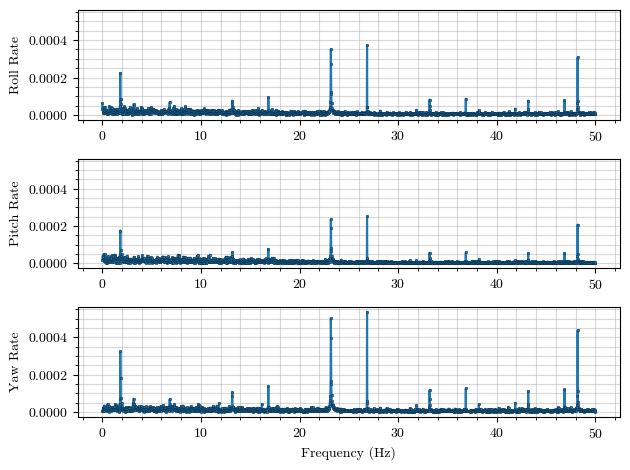

In [116]:
# Generating FFT of rotation rates

i = 0

segment_length = len(v_tas[cal_masks[i]])            # Integer segment length
time_s = np.linspace(t_init, (segment_length-1)*dT + t_init, segment_length)

plt.figure()
plt.plot(time_s, P[cal_masks[i]])
plt.xlabel("Time (s)")
plt.ylabel("Roll Rate (rad/s)")
plt.show()

# Getting Rates for Single Acceleration
p_fft = np.fft.fft(P[cal_masks[i]])
q_fft = np.fft.fft(Q[cal_masks[i]])
r_fft = np.fft.fft(R[cal_masks[i]])

xf = np.linspace(0.0, 1.0/(2.0*dT), segment_length//2)

plt.figure()

ax0 = plt.subplot(3,1,1)
ax1 = plt.subplot(3,1,2, sharey=ax0)
ax2 = plt.subplot(3,1,3, sharey=ax0)
ax0.plot(xf, 2.0/segment_length * np.abs(p_fft[:segment_length//2]))
ax1.plot(xf, 2.0/segment_length * np.abs(q_fft[:segment_length//2]))
ax2.plot(xf, 2.0/segment_length * np.abs(r_fft[:segment_length//2]))
ax0.set_ylabel("Roll Rate")
ax1.set_ylabel("Pitch Rate")
ax2.set_ylabel("Yaw Rate")
ax2.set_xlabel("Frequency (Hz)")
plt.show()

## Post-Flight IMU Orientation Calibration

### Calculating Body Accelerations w. Adjustment for g Magnitude

In [117]:
thetap = 0.0 * (np.pi/180)  # Pitch perturbation from IMU orientation (Degrees)
phip = 0.0 * (np.pi/180)  # Roll perturbation from IMU orientation (Degrees)

IMUtotal = (np.sqrt(xp_acc**2 + yp_acc**2 + zp_acc**2))
g_IMU = np.mean(IMUtotal[cal_masks[0]])
print(g_IMU)

U_dot = xp_acc - g_IMU * np.sin(theta)
V_dot = yp_acc + g_IMU * np.cos(theta) * np.sin(phi)
W_dot = zp_acc + g_IMU * np.cos(theta) * np.cos(phi)

9.790996802462441


### Calculating Body Accelerations w. Adjustment for IMU Orientation

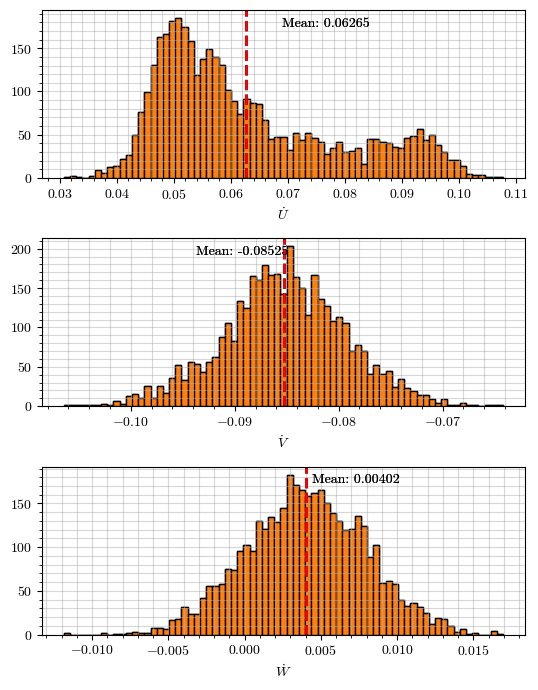

Plot already exists


In [118]:
U_dotp = xp_acc - (g_IMU * np.sin(theta+thetap))
V_dotp = yp_acc + (g_IMU * np.cos(theta+thetap) * np.sin(phi+phip))
W_dotp = zp_acc + (g_IMU * np.cos(theta+thetap) * np.cos(phi+phip))

alpha_adjusted = (theta+thetap) - gamma

def plot_hist(masks):

    angle_offset_calibration = plt.figure(figsize=(5.5, 7))
    plt.title("Body Accelerations in X Direction")
    i = 0
    ax0 = plt.subplot(3,1,1)
    ax0.hist(U_dotp[masks[i]], bins=71, edgecolor='k', label='Adjusted')
    ax0.hist(U_dot[masks[i]], bins=71, edgecolor='k', label='Original')
    ax0.axvline(np.mean(U_dotp[masks[i]]), color='k', linestyle='dashed', linewidth=2)
    ax0.axvline(np.mean(U_dot[masks[i]]), color='r', linestyle='dashed', linewidth=2)
    ax0.set_xlabel("$\dot{U}$")
    min_ylim, max_ylim = ax0.set_ylim()
    ax0.text(U_dotp[masks[i]].mean()*1.1, max_ylim*0.9, 'Mean: {:.5f}'.format(U_dotp[masks[i]].mean()))
    ax0.text(U_dot[masks[i]].mean()*1.1, max_ylim*0.9, 'Mean: {:.5f}'.format(U_dot[masks[i]].mean()))

    ax1 = plt.subplot(3,1,2)
    ax1.hist(V_dotp[masks[i]], bins=71, edgecolor='k', label='Adjusted')
    ax1.hist(V_dot[masks[i]], bins=71, edgecolor='k', label='Original')
    ax1.axvline(np.mean(V_dotp[masks[i]]), color='k', linestyle='dashed', linewidth=2)
    ax1.axvline(np.mean(V_dot[masks[i]]), color='r', linestyle='dashed', linewidth=2)
    ax1.set_xlabel("$\dot{V}$")
    min_ylim, max_ylim = ax1.set_ylim()
    ax1.text(V_dotp[masks[i]].mean()*1.1, max_ylim*0.9, 'Mean: {:.5f}'.format(V_dotp[masks[i]].mean()))
    ax1.text(V_dot[masks[i]].mean()*1.1, max_ylim*0.9, 'Mean: {:.5f}'.format(V_dot[masks[i]].mean()))

    ax2 = plt.subplot(3,1,3)
    ax2.hist(W_dotp[masks[i]], bins=71, edgecolor='k', label='Adjusted')
    ax2.hist(W_dot[masks[i]], bins=71, edgecolor='k', label='Original')
    ax2.axvline(np.mean(W_dotp[masks[i]]), color='k', linestyle='dashed', linewidth=2)
    ax2.axvline(np.mean(W_dot[masks[i]]), color='r', linestyle='dashed', linewidth=2)
    ax2.set_xlabel("$\dot{W}$")
    min_ylim, max_ylim = ax2.set_ylim()
    ax2.text(W_dotp[masks[i]].mean()*1.1, max_ylim*0.9, 'Mean: {:.5f}'.format(W_dotp[masks[i]].mean()))
    ax2.text(W_dot[masks[i]].mean()*1.1, max_ylim*0.9, 'Mean: {:.5f}'.format(W_dot[masks[i]].mean()))

    plt.show()
    main.save_figure(angle_offset_calibration, f'{angle_offset_calibration=}'.split('=')[0], figure_path)

plot_hist(cal_masks)

## Main Analysis for Power Required

### Power Required Without IMU Orientation Adjustment

In [119]:
# Beginning Power Required Calculation without IMU Orientation Adjustment

CT = prop.thrust_coeff(J)
T = CT * rho * n**2 * prop.diameter**4

P_req_t1 = (T * v_tas)
P_req_t2 = (mass * g * Vd_tas)
P_req_t3 = -(mass * U_dot * v_tas)
P_req_t4 = -(mass * W_dot * v_tas * alpha)
P_req_t5 = mass * v_tas * (Q*U*alpha - Q*W)
P_req_t6 = mass * v_tas * (R*V - P*V)

P_req_simple = P_req_t1 + P_req_t2 + P_req_t3
P_req_wdot = P_req_t1 + P_req_t2 + P_req_t3 + P_req_t4
P_req_rates = P_req_t1 + P_req_t2 + P_req_t3 + P_req_t4 + P_req_t5 + P_req_t6

D_simple = P_req_simple / v_tas
D_wdot = P_req_wdot / v_tas
D_rates = P_req_rates / v_tas

CD_simple = D_simple / (0.5 * rho * v_tas**2 * linus.area) # still need to estimate the wing area of createv
CD_wdot = D_wdot / (0.5 * rho * v_tas**2 * linus.area) # still need to estimate the wing area of createv
CD_rates = D_rates / (0.5 * rho * v_tas**2 * linus.area) # still need to estimate the wing area of createv

/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_59779/3302564485.py:17: RuntimeWarning: divide by zero encountered in true_divide
  D_simple = P_req_simple / v_tas


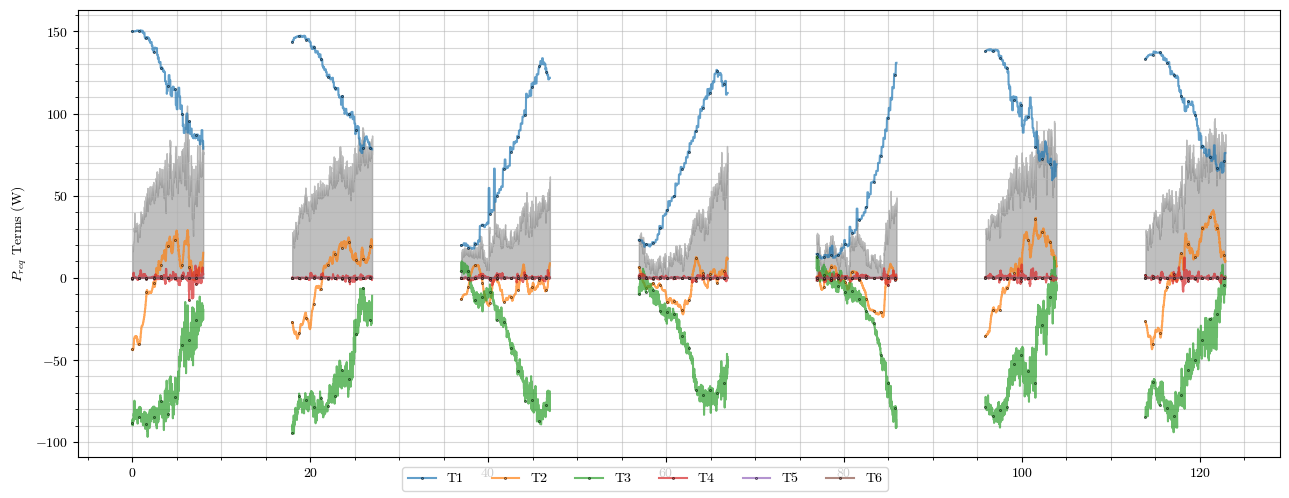

Plot already exists


In [120]:
# Power Required Terms Comparison
[tiemindex_Preq_segmented, axs] = plt.subplots(1,1, sharex=True, figsize=(13,5), dpi=100)
# timeindex_v_h_RPM_segmented.subplots_adjust(right=0.2, left=0.1)

markerevery=80
markedgew=0.5
t_init = 0
dT = 0.01
for i in range(len(masks)):
    segment_length = len(v_tas[masks[i]])            # Integer segment length
    time_s = np.linspace(t_init, (segment_length-1)*dT + t_init, segment_length)
    # Airspeed for Segments
    axs.plot(time_s, P_req_t1[masks[i]], linestyle='-', markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, color='#1f77b4', alpha=0.7)
    axs.plot(time_s, P_req_t2[masks[i]], linestyle='-', markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, color='#ff7f0e', alpha=0.7)
    axs.plot(time_s, P_req_t3[masks[i]], linestyle='-', markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, color='#2ca02c', alpha=0.7)
    axs.plot(time_s, P_req_t4[masks[i]], linestyle='-', markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, color='#d62728', alpha=0.7)
    axs.plot(time_s, P_req_t5[masks[i]], linestyle='-', markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, color='#9467bd', alpha=0.7)
    axs.plot(time_s, P_req_t6[masks[i]], linestyle='-', markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, color='#8c564b', alpha=0.7)
    axs.fill_between(time_s, np.zeros(np.shape(P_req_wdot[masks[i]])), P_req_wdot[masks[i]], color='grey', alpha=0.5)
    t_init = time_s[-1]+10

tiemindex_Preq_segmented.legend(["T1", "T2", "T3", "T4", "T5", "T6"], loc='lower center', ncol=6)
axs.set_ylabel("$P_{req}$ Terms (W)")

plt.show()
main.save_figure(tiemindex_Preq_segmented, f'{tiemindex_Preq_segmented=}'.split('=')[0], figure_path)

### Lift Measurement without IMU Orientation Adjustment

In [121]:
L_t1 = linus.weight * np.ones(np.shape(W_dot))
L_t2 = -1*(linus.mass * W_dot)
L_t3 = -1*(alpha*T)
L_t4 = alpha*linus.mass*U_dot

L_simple = L_t1 + L_t2
L_full = L_t1 + L_t2 + L_t3 + L_t4

CL_simple = L_simple / (0.5 * rho * v_tas**2 * linus.area)
CL_full = L_full / (0.5 * rho * v_tas**2 * linus.area)
# CL = cl_finders.cl_usbanked(createv, q, phi, W_dot)

/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_59779/1986525531.py:9: RuntimeWarning: divide by zero encountered in true_divide
  CL_simple = L_simple / (0.5 * rho * v_tas**2 * linus.area)


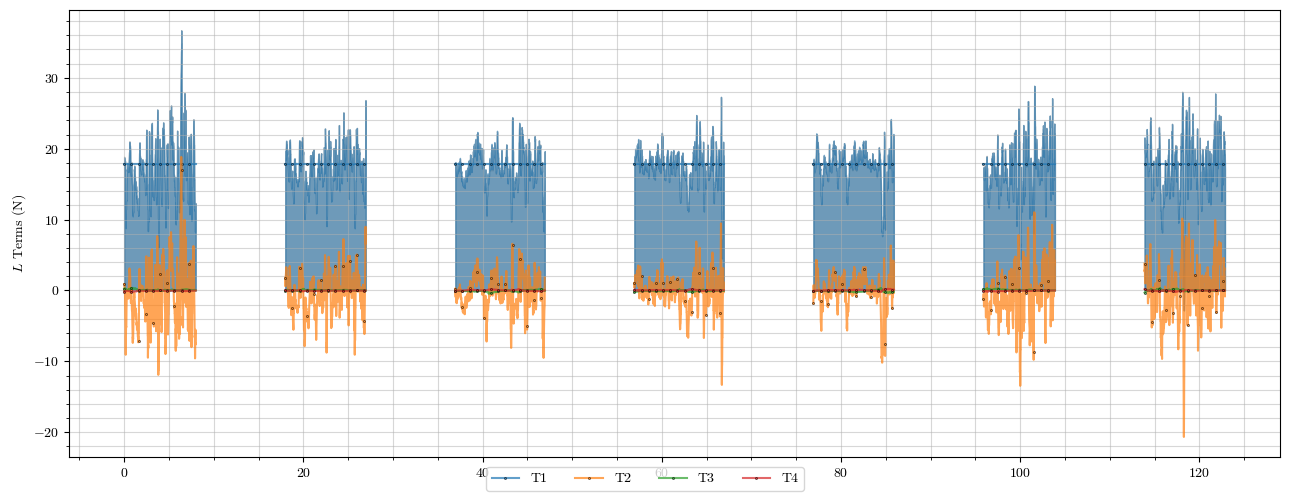

In [122]:
# Lift Term Comparison
[fig, axs] = plt.subplots(1,1, sharex=True, figsize=(13,5), dpi=100)
# timeindex_v_h_RPM_segmented.subplots_adjust(right=0.2, left=0.1)

markerevery=80
markedgew=0.5
t_init = 0
dT = 0.01
for i in range(len(masks)):
    segment_length = len(v_tas[masks[i]])            # Integer segment length
    time_s = np.linspace(t_init, (segment_length-1)*dT + t_init, segment_length)
    # Airspeed for Segments
    axs.plot(time_s, L_t1[masks[i]], linestyle='-', markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, color='#1f77b4', alpha=0.7)
    axs.plot(time_s, L_t2[masks[i]], linestyle='-', markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, color='#ff7f0e', alpha=0.7)
    axs.plot(time_s, L_t3[masks[i]], linestyle='-', markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, color='#2ca02c', alpha=0.7)
    axs.plot(time_s, L_t4[masks[i]], linestyle='-', markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, color='#d62728', alpha=0.7)
    axs.fill_between(time_s, np.zeros(np.shape(L_full[masks[i]])), L_full[masks[i]], color='grey', alpha=0.5)
    axs.fill_between(time_s, np.zeros(np.shape(L_simple[masks[i]])), L_simple[masks[i]], color='#1f77b4', alpha=0.5)
    t_init = time_s[-1]+10

fig.legend(["T1", "T2", "T3", "T4"], loc='lower center', ncol=6)
axs.set_ylabel("$L$ Terms (N)")

plt.show()
# main.save_figure(timeindex_v_h_RPM_segmented, f'{timeindex_v_h_RPM_segmented=}'.split('=')[0], figure_path)

## Collecting Total Results for Polar

In [123]:
# Collecting Total CL, CD's
cl_total = cl_finders.total_segments_boolean(CL_simple, masks)
cd_total = cl_finders.total_segments_boolean(CD_wdot, masks)

## Binning Total Results for Polar

In [134]:
bins = np.linspace(0.05, 1.4, 50)
[cl_bin_means, cl_bin_stds, cl_bin_ci95s, cd_bin_means, cd_bin_stds, cd_bin_ci95s] = cl_finders.collect_bins(np.linspace(0.05, 0.8, 50), cl_total, cd_total)

## Plotting Results of Binning

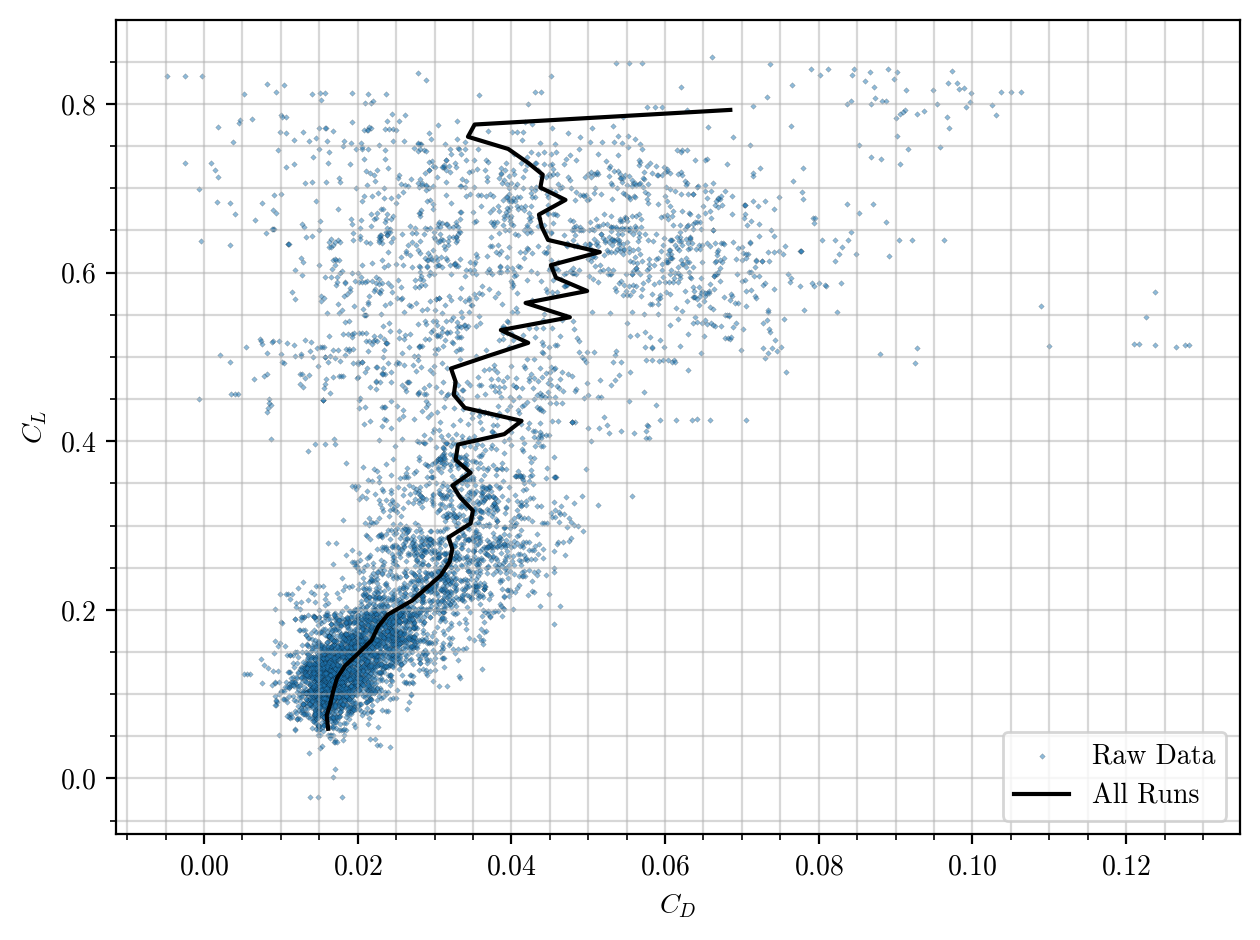

Plot already exists


In [135]:
fig_dragpolar = plt.figure(dpi=200)
plt.scatter(cd_total, cl_total, marker='D', alpha=0.5, edgecolors=[0,0,0], s=2, linewidths=0.1, label='Raw Data')
plt.plot(cd_bin_means, cl_bin_means, marker='', markeredgecolor=[0,0,0], markersize=5, markeredgewidth=markedgew, linestyle='-', color='black', label='All Runs')
plt.legend()
plt.xlabel("$C_D$")
plt.ylabel("$C_L$")
plt.show()
main.save_figure(fig_dragpolar, f'{fig_dragpolar=}'.split('=')[0], figure_path)

## Performing Curve Fits to Find Polars

In [136]:
polar_acceleration = cl_finders.cd2polar(linus, cd_total, cl_total, highorder=False)
print(polar_acceleration)

0.07062327949352765
[0.02101263 0.31716063]


## Packaging the Results

In [137]:
acceleration_binresult = cl_finders.packaging_binresults(cl_total, cl_bin_means, cl_bin_stds, cl_bin_ci95s, cd_total, cd_bin_means, cd_bin_stds, cd_bin_ci95s, polar_acceleration, linus)

## Saving Results to Disk

In [138]:
# Exporting polar data
pd.to_pickle(acceleration_binresult, result_path+'acceleration_allresult.pkl')

## Additional Plots

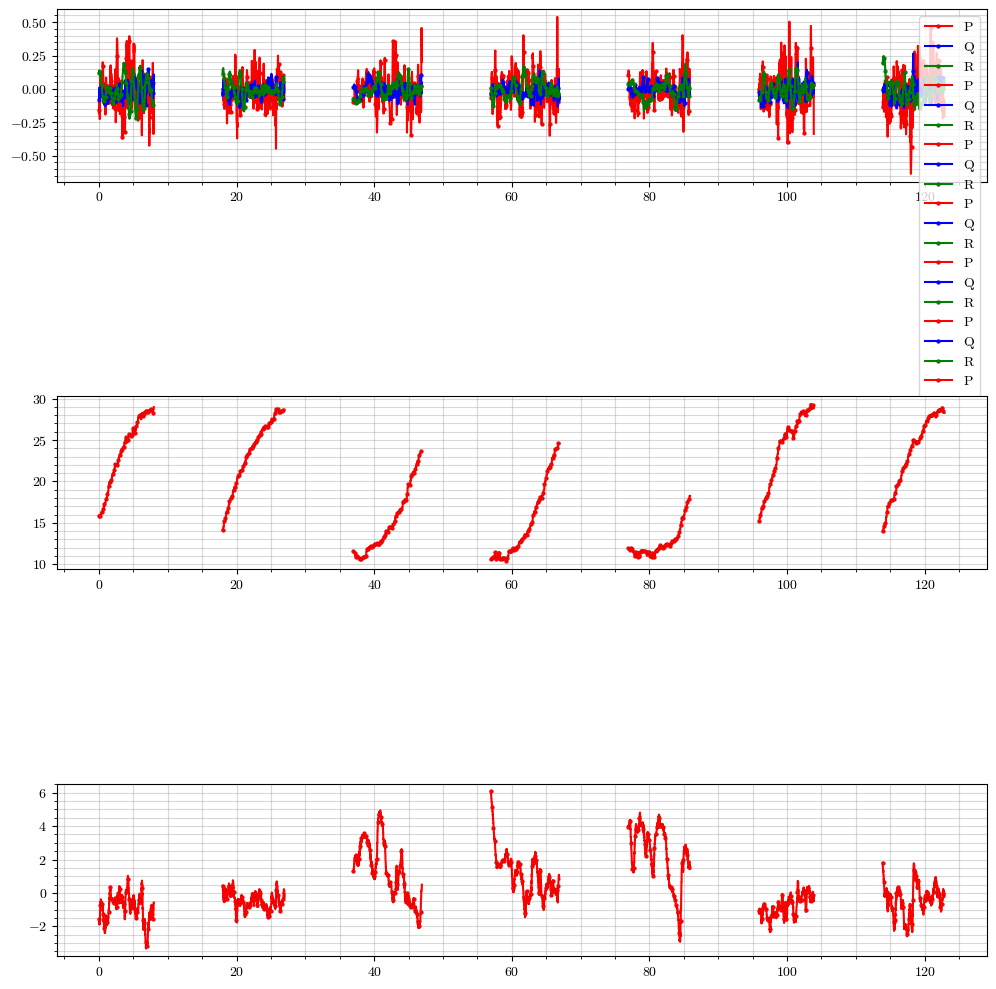

In [139]:
# Plotting the Rotational Rates
markerstyle = 'o'
markerevery = 20
markedgew = 0.05

t_init = 0

plt.figure(figsize=(10,10))
plt.tight_layout()
t_init = 0

ax1 = plt.subplot(3,1,1)
ax2 = plt.subplot(3,1,2, sharex=ax1)
ax3 = plt.subplot(3,1,3, sharex=ax1)
for i in range(len(masks)):
    time_s = np.linspace(t_init, (len(v_tas[masks[i]])-1)/100 + t_init, len(v_tas[masks[i]]))
    ax1.plot(time_s, P[masks[i]], color='r', marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, label='P')
    ax1.plot(time_s, Q[masks[i]], color='b', marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, label='Q')
    ax1.plot(time_s, R[masks[i]], color='g', marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, label='R')
    ax2.plot(time_s, v_tas[masks[i]], color='r', marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    ax3.plot(time_s, np.rad2deg(alpha[masks[i]]), color='r', marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    t_init = time_s[-1]+10
ax1.grid(True)
ax2.grid(True)
ax1.legend()
plt.show()

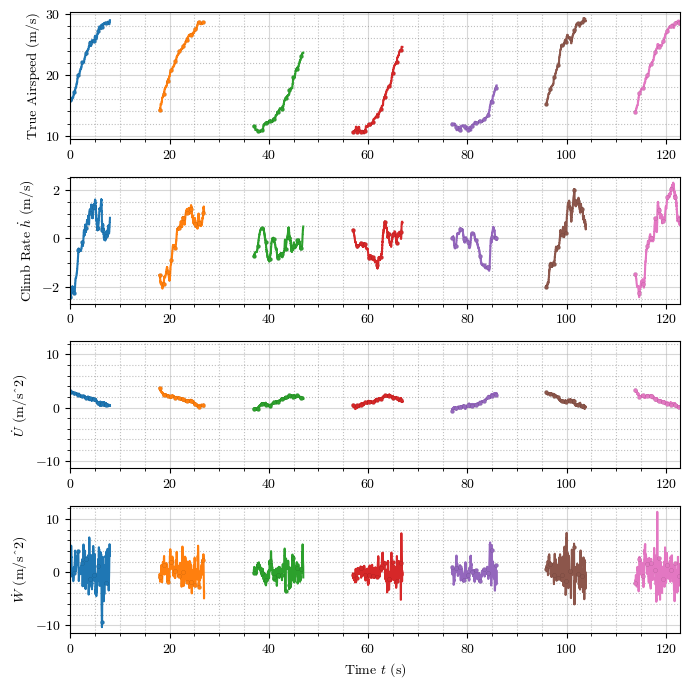

In [140]:
# Plotting Acceleration Runs
markerstyle = 'o'
markerevery = 80
markedgew = 0.05
plt.figure(figsize=(7,7))
ax1 = plt.subplot(4,1,1)
t_init = 0
for i in range(len(masks)):
    time_s = np.linspace(t_init, (len(v_tas[masks[i]])-1)/100 + t_init, len(v_tas[masks[i]]))
    ax1.plot(time_s, v_tas[masks[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    t_init = time_s[-1]+10
ax1.set_ylabel("True Airspeed (m/s)")
ax1.grid(which='major', linestyle='-')
ax1.grid(which='minor', linestyle=':', color='grey')
ax1.autoscale(enable=True, axis='x', tight=True)

ax0 = plt.subplot(4,1,2, sharex=ax1)
t_init = 0
for i in range(len(masks)):
    time_s = np.linspace(t_init, (len(v_tas[masks[i]])-1)/100 + t_init, len(v_tas[masks[i]]))
    ax0.plot(time_s, Vd_tas[masks[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    t_init = time_s[-1]+10
ax0.set_ylabel("Climb Rate $\dot{h}$ (m/s)")
ax0.grid(which='major', linestyle='-')
ax0.grid(which='minor', linestyle=':', color='grey')
ax0.autoscale(enable=True, axis='x', tight=True)

ax2 = plt.subplot(4,1,3, sharex=ax1)
t_init = 0
for i in range(len(masks)):
    time_s = np.linspace(t_init, (len(v_tas[masks[i]])-1)/100 + t_init, len(v_tas[masks[i]]))
    ax2.plot(time_s, U_dot[masks[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    t_init = time_s[-1]+10
ax2.set_ylabel("$\dot{U}$ (m/s^2)")
ax2.grid(which='major', linestyle='-')
ax2.grid(which='minor', linestyle=':', color='grey')
ax2.autoscale(enable=True, axis='x', tight=True)

ax3 = plt.subplot(4,1,4, sharex=ax1, sharey=ax2)
t_init = 0
for i in range(len(masks)):
    time_s = np.linspace(t_init, (len(v_tas[masks[i]])-1)/100 + t_init, len(v_tas[masks[i]]))
    ax3.plot(time_s, W_dot[masks[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    t_init = time_s[-1]+10
ax3.set_ylabel("$\dot{W}$ (m/s^2)")
ax3.set_xlabel("Time $t$ (s)")
ax3.grid(which='major', linestyle='-')
ax3.grid(which='minor', linestyle=':', color='grey')
ax3.autoscale(enable=True, axis='x', tight=True)

plt.tight_layout()
plt.show()

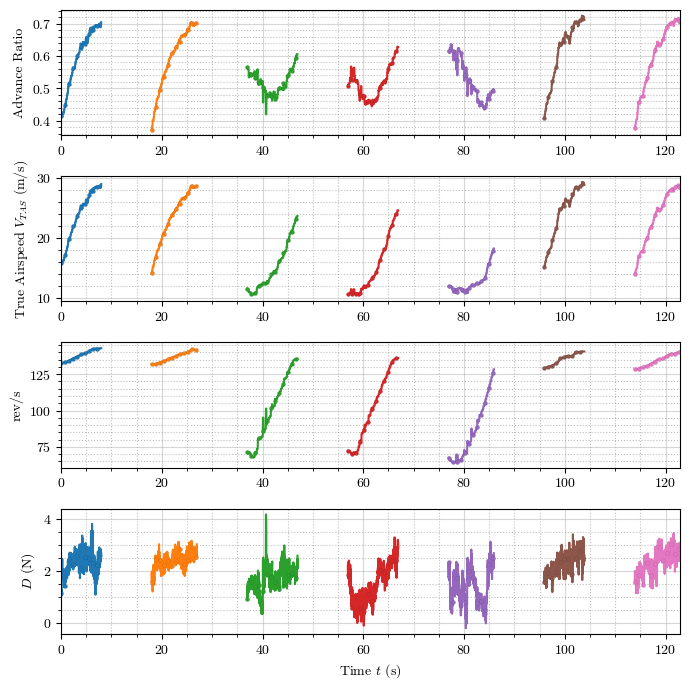

In [141]:
# Plotting Acceleration Runs
markerstyle = 'o'
markerevery = 80
markedgew = 0.05
plt.figure(figsize=(7,7))
ax1 = plt.subplot(4,1,1)
t_init = 0
for i in range(len(masks)):
    time_s = np.linspace(t_init, (len(v_tas[masks[i]])-1)/100 + t_init, len(v_tas[masks[i]]))
    ax1.plot(time_s, J[masks[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    t_init = time_s[-1]+10
ax1.set_ylabel("Advance Ratio")
ax1.grid(which='major', linestyle='-')
ax1.grid(which='minor', linestyle=':', color='grey')
ax1.autoscale(enable=True, axis='x', tight=True)

ax0 = plt.subplot(4,1,2, sharex=ax1)
t_init = 0
for i in range(len(masks)):
    time_s = np.linspace(t_init, (len(v_tas[masks[i]])-1)/100 + t_init, len(v_tas[masks[i]]))
    ax0.plot(time_s, v_tas[masks[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    t_init = time_s[-1]+10
ax0.set_ylabel("True Airspeed $V_{TAS}$ (m/s)")
ax0.grid(which='major', linestyle='-')
ax0.grid(which='minor', linestyle=':', color='grey')
ax0.autoscale(enable=True, axis='x', tight=True)

ax2 = plt.subplot(4,1,3, sharex=ax1)
t_init = 0
for i in range(len(masks)):
    time_s = np.linspace(t_init, (len(v_tas[masks[i]])-1)/100 + t_init, len(v_tas[masks[i]]))
    ax2.plot(time_s, n[masks[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    t_init = time_s[-1]+10
ax2.set_ylabel("rev/s")
ax2.grid(which='major', linestyle='-')
ax2.grid(which='minor', linestyle=':', color='grey')
ax2.autoscale(enable=True, axis='x', tight=True)

ax3 = plt.subplot(4,1,4, sharex=ax1)
t_init = 0
for i in range(len(masks)):
    time_s = np.linspace(t_init, (len(v_tas[masks[i]])-1)/100 + t_init, len(v_tas[masks[i]]))
    ax3.plot(time_s, D[masks[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    t_init = time_s[-1]+10
ax3.set_ylabel("$D$ (N)")
ax3.set_xlabel("Time $t$ (s)")
ax3.grid(which='major', linestyle='-')
ax3.grid(which='minor', linestyle=':', color='grey')
ax3.autoscale(enable=True, axis='x', tight=True)

plt.tight_layout()
plt.show()

In [144]:
# Fitting only to CL 1.1 and less

[CL_fitted_ACC, CD_fitted_ACC] = cl_finders.plotfittedpolar(linus, polar_acceleration, [0.05, 0.8])

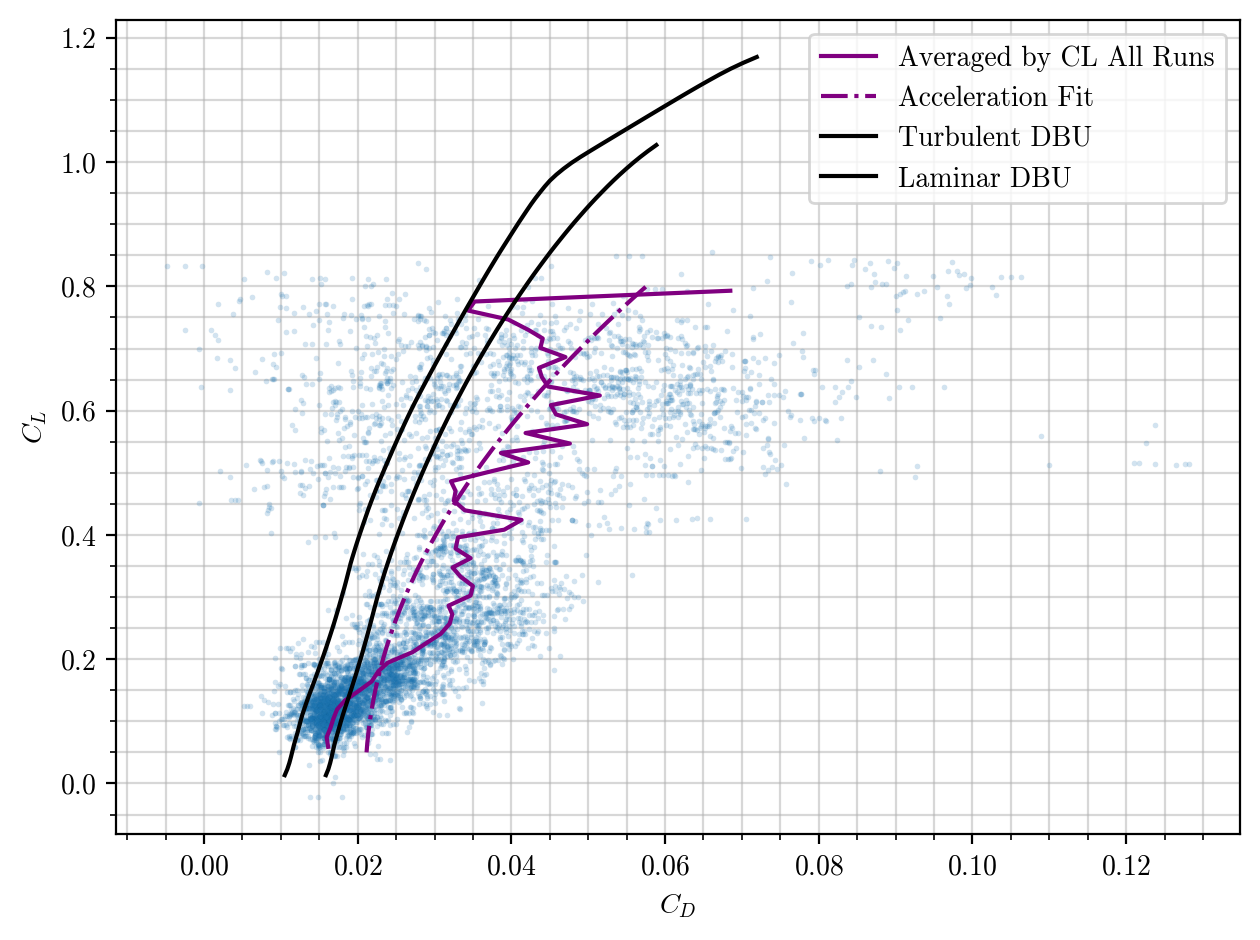

Plot already exists


In [145]:
fig_dragpolar_context = plt.figure(dpi=200)

plt.plot(cd_total, cl_total, marker="o", markersize=2, markeredgewidth=0.01, markeredgecolor='black', linestyle='', alpha=0.2)
plt.plot(cd_bin_means, cl_bin_means, marker='', color='purple', markeredgecolor=[0,0,0], markersize=5, markeredgewidth=markedgew, linestyle='-', label='Averaged by CL All Runs')

plt.plot(CD_fitted_ACC, CL_fitted_ACC, marker='', color='purple', linestyle='-.', label="Acceleration Fit")

plt.plot(build_turbulent.CD[:106], build_turbulent.CL[:106], marker='', color='black', linestyle='solid', label="Turbulent DBU")
plt.plot(build_laminar.CD, build_laminar.CL, marker='', color='black', linestyle='solid', label="Laminar DBU")

plt.legend()
plt.xlabel("$C_D$")
plt.ylabel("$C_L$")
plt.show()
main.save_figure(fig_dragpolar_context, f'{fig_dragpolar_context=}'.split('=')[0], figure_path)

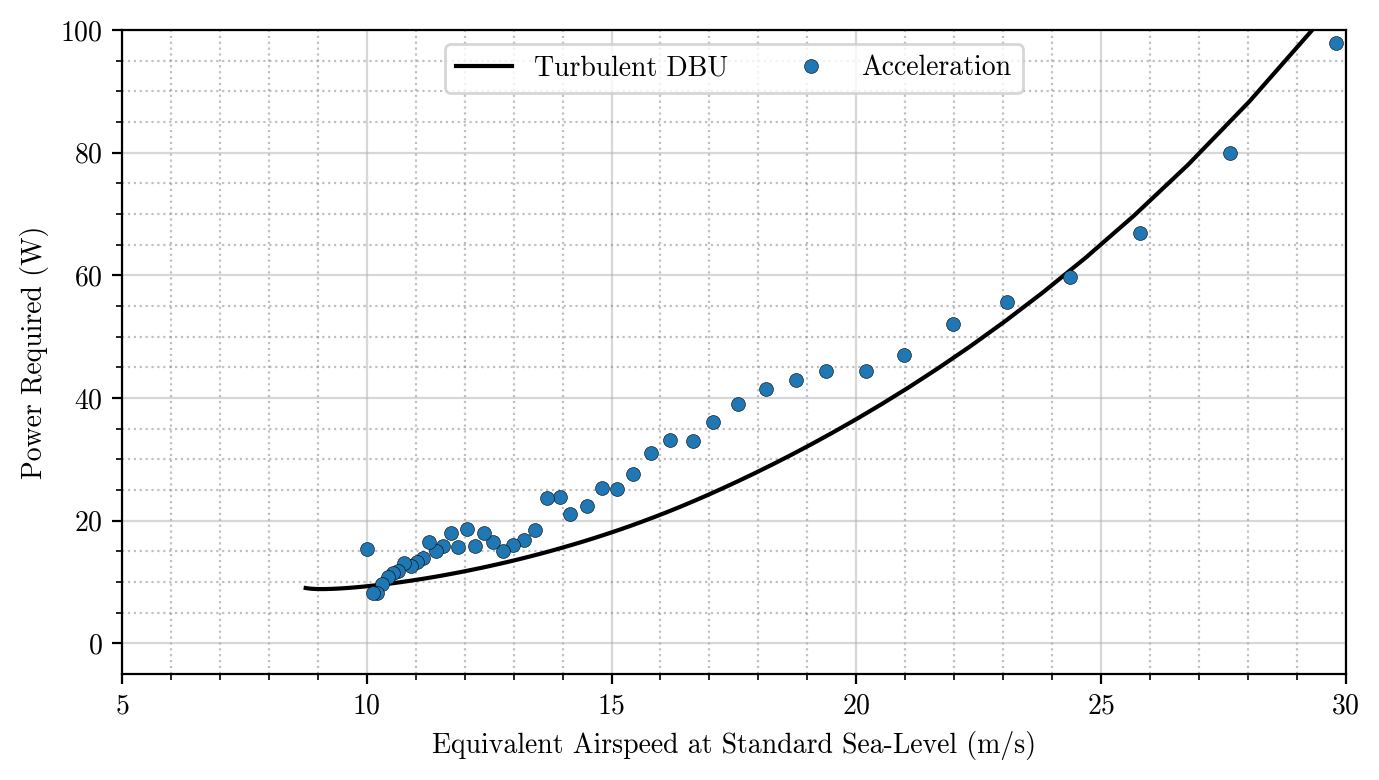

In [148]:
# Plot of Power Required Fits and Data #

[Pbin_acc, EAS_acc] = cl_finders.rawpolar2preqew(linus, cl_bin_means, cd_bin_means)
[P_dbu, EAS_dbu] = cl_finders.rawpolar2preqew(linus, build_turbulent.CL, build_turbulent.CD)

fig_Preq_context = plt.figure(figsize=(7,4), dpi=200)
plt.errorbar(EAS_acc, Pbin_acc, label="Acceleration", linestyle='', marker='o', markersize=5)
plt.plot(EAS_dbu, P_dbu, marker='', color='black', label='Turbulent DBU')

plt.xlabel("Equivalent Airspeed at Standard Sea-Level (m/s)")
plt.ylabel("Power Required (W)")
plt.legend(loc='upper center', ncol=4)
plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':', color='grey')
plt.minorticks_on()
plt.tight_layout()
plt.xlim([5,30])
plt.ylim([-5, 100])
plt.show()
main.save_figure(fig_Preq_context, f'{fig_Preq_context=}'.split('=')[0], figure_path, overwrite=True)